## Streaming


In [1]:
%pip install --quiet -U langgraph langchain_groq langgraph_sdk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 652.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.7 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
apikey = userdata.get('GROQ_API_KEY')

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey)

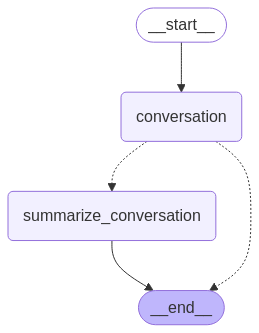

In [4]:
from IPython.display import Image, display

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# State
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming full state


stream_mode="updates"

In [5]:
config = {"configurable" : {'thread_id' : '1'} }

for chunk in graph.stream({"messages": [HumanMessage(content='hi, i am zeeshan')]}, config, stream_mode="updates"):
  print(chunk)

{'conversation': {'messages': AIMessage(content="Hello Zeeshan, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 42, 'total_tokens': 70, 'completion_time': 0.101818182, 'prompt_time': 0.005258031, 'queue_time': 0.266936244, 'total_time': 0.107076213}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c4760ee73b', 'finish_reason': 'stop', 'logprobs': None}, id='run-7fa140f4-dff2-4da9-a773-83276e448cc8-0', usage_metadata={'input_tokens': 42, 'output_tokens': 28, 'total_tokens': 70})}}


In [6]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm zeeshan")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi again Zeeshan. It seems like we already said hello. Is everything okay? Would you like to talk about something specific or just have a casual conversation? I'm here to listen and help if I can.


stream_mode = "values

In [7]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm zeeshan")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm zeeshan
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm zeeshan
================================== Ai Message ==================================

Hello Zeeshan, it's nice to meet you. Is there something I can help you with or would you like to chat?
---------------------------------------------------------------------------


## Streaming tokens
.astream_events method

In [8]:
config = {"configurable": {"thread_id": "3"}}

input_message = HumanMessage(content="Tell me about the pakistan cricket team")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):

    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_stream. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Type: on_chat_model_stream. Name: ChatGroq
Node: conversation. Ty

In [9]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the pakistan cricket team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-067c0502-7718-4bbd-b32f-11fe6e6cad49')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-067c0502-7718-4bbd-b32f-11fe6e6cad49')}
{'chunk': AIMessageChunk(content=' Pakistan', additional_kwargs={}, response_metadata={}, id='run-067c0502-7718-4bbd-b32f-11fe6e6cad49')}
{'chunk': AIMessageChunk(content=' cricket', additional_kwargs={}, response_metadata={}, id='run-067c0502-7718-4bbd-b32f-11fe6e6cad49')}
{'chunk': AIMessageChunk(content=' team', additional_kwargs={}, response_metadata={}, id='run-067c0502-7718-4bbd-b32f-11fe6e6cad49')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, response_metadata={}, id='run-067c0502-7718-4bbd-b32f-11fe6e6cad49')}
{'chunk': AIMessageChunk(content=' also', additional_kwargs={}, response_metadata={}, id='run-067c0502-7718-4bbd-b32f-11fe6e6cad49')}
{'chunk': AIMessageChunk(content=' known', additional_kwargs={}, r

In [10]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the pakistan cricket team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| Pakistan| cricket| team|,| also| known| as| the| Sha|he|ens| (|Ur|du|:| ش|ا|ہ|ین|),| is| the| national| cricket| team| of| Pakistan|.| The| team| is| governed| by| the| Pakistan| Cricket| Board| (|PC|B|)| and| is| a| full| member| of| the| International| Cricket| Council| (|ICC|).

|**|History|:|**
|Pakistan| played| its| first| Test| match| in| |195|2|,| against| India|,| and| has| since| become| one| of| the| most| successful| and| popular| cricket| teams| in| the| world|.| The| team| has| a| rich| history|,| with| many| notable| players|,| including| Han|if| Mohammad|,| Im|ran| Khan|,| J|aved| Mi|and|ad|,| Was|im| Ak|ram|,| and| Wa|q|ar| You|nis|.

|**|International| Performance|:|**
|Pakistan| has| had| a| significant| impact| on| international| cricket|,| with| several| notable| achievements|:

|1|.| **|World| Cup| wins|:**| Pakistan| won| the| |199|2| Cricket| World| Cup|,| led| by| Im|ran| Khan|,| and| were| runners|-up| in| |199|9|.
|2|.| **|Test| cricket|:**| Pakistan| h